### 提醒
- 資料集只有 train.csv 沒有用 test.csv
- 切出 trian valid test 3個set
- 主要function 是 genrate_data_set() 

### genrate_data_set(trainDataPath = "/content/train.csv", fillna="NA", dropRareTH=0.005, cutSize=[0.2,0.1],addFT= True )

#### args
- trainDataPath: str, path to train.csv
- fillna: str, the mode to fill NaN "NA","mode","mice"
- dropRareTH: float, the threshold to replacee low frequency categorical to other    <br>(Only apply on ["mchno""scity","mcc"])
- cutSize: array, a array of val size and test size.
<br> e.g [0.1,0.2] means train:0.7 val:0.1 test:0.2
<br> Notice: train and val are a balance data , while test is a inbalance data.
-addFT: bool, add Feature or not

#### return
&nbsp; &nbsp; x_train, x_val, x_test, y_train, y_val, y_test 

# 載入資料

In [ ]:
# # 如果有使用 coloab 再執行此 cell
# from google.colab import drive
# drive.mount('/gdrive'

In [ ]:
f1id = '1SvJ_IiHr-ndJDG_sBf6NCn0lMKUxPIlf'
f2id = '1lZPv46zul32Xbr1qHES66YRzMa-A7MzB'


!pip3 install gdown
import gdown
url = 'https://drive.google.com/uc?id=%s'%(f1id)
output = 'train.csv'
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1SvJ_IiHr-ndJDG_sBf6NCn0lMKUxPIlf
To: /content/train.csv
132MB [00:00, 208MB/s]


'train.csv'

In [ ]:
! mkdir data model submit
!pip install miceforest

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘model’: File exists
mkdir: cannot create directory ‘submit’: File exists
  Using cached https://files.pythonhosted.org/packages/24/33/5568d443ba438d95d4db635dd69958056f087e57e1026bee56f959d53f9d/matplotlib-3.4.2-cp37-cp37m-manylinux1_x86_64.whl
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


In [ ]:
import pandas as pd
import numpy as np

# Load Data and Overview

In [ ]:
#產生 dataSet
def loadData(path):
  x_all = pd.read_csv(path).set_index('txkey')
  print(x_all.shape)
  x_all.sort_values(by=['locdt'],inplace=True)
  y_all = x_all['fraud_ind']
  del x_all['fraud_ind']
  return x_all, y_all

In [ ]:
# x_all, y_al = loadData("/content/train.csv")
# print(addFeature(x_all,False))

In [ ]:
def addFeature(df,addFT):
  if addFT:
    df_time = df["loctm"].copy().apply(str).apply(lambda x: x.zfill(8))
    df_time = df_time.str.split("",expand=True)
    df_abs_time =  df["locdt"].astype("int")*86400 + (df_time[1].astype("int")*10 +df_time[2].astype("int"))*3600 + (df_time[3].astype("int")*10 +df_time[4].astype("int"))*60 +(df_time[5].astype("int")*10 +df_time[6].astype("int"))
    df_hours = df_time[1].astype("int")*10 +df_time[2].astype("int")
    df_minutes = df_time[3].astype("int")*10 +df_time[4].astype("int")
    df_seconds = df_time[5].astype("int")*10 +df_time[6].astype("int")
    df = df.assign(abs_time=df_abs_time)
    df = df.assign(hours=df_hours)
    df = df.assign(hours2=df_hours)
    df = df.assign(minutes=df_minutes)
    df = df.assign(seconds=df_seconds)
    return df
  else:
    return df

In [ ]:
def delFeature(df,delFT):
  if delFT:
    for i in df.keys():
      if i not in ['acqic', 'loctm', 'scity', 'ecfg', 'etymd', 'hcefg', 'stocn', 'stscd']:
        del df[i]
  return df

In [ ]:
# 欄位類別判定
def analysis(df,dropRareTH,addFT,delFT):
  col_names_cont = [] # 數值型資料
  col_names_disc = [] # 類別型資料
  col_has_na = [] # 待補NA資料

  # Replace low frequency categorical to other
  if delFT==False:
    df[["mchno","scity","mcc"]] = df[["mchno","scity","mcc"]].apply(lambda x: x.mask(x.map(x.value_counts(normalize=True))<dropRareTH, 99999))

  for c in df.keys():
      uni = df[c].unique()
      n_na = pd.isna(df[c]).sum() # NA 數量
      print(len(uni))
      if n_na > 0:
          col_has_na.append(c)       
      if len(uni) < 200 :
          print(f"{c}: uni={uni}")
          col_names_disc.append(c)
      else: 
          info = [ df[c].max(), df[c].min(), df[c].mean(), df[c].std()]
          info = [ round(x,2) for x in info ]
          offset = 1 if n_na else 0
          diversity = (len(uni)-offset)/(len(df)-n_na)
          print(f"{c}: dtype={df[c].dtype}, n_na={n_na}")
          print("       max={}, min={}, mean={}, std={}, diversity={:.2f}%".format(*info, diversity*100 ) )
          if diversity == 1.0:
              print(f"       Delete col [{c}] due to diversity is 100% ")
          else:
              col_names_cont.append(c)
      # locdt is numerical
  # if delFT == False:
  #   col_names_disc.remove('locdt')
  #   col_names_cont.append('locdt')
  if addFT and delFT == False:
    col_names_disc.remove('hours')
    col_names_cont.append('hours')
    col_names_disc.remove('minutes')
    col_names_cont.append('minutes')
    col_names_disc.remove('seconds')
    col_names_cont.append('seconds')

  return col_names_cont, col_names_disc, col_has_na

In [ ]:
#spilt data set
from sklearn.model_selection import train_test_split
def spiltDataSet(x_data,y_data,size):
  x_1, x_2, y_1, y_2,= train_test_split(x_data, y_data, test_size=size, random_state=111, shuffle=False)
  return x_1, x_2, y_1, y_2,


- 看起來數值型資料都沒有缺失值(n_na==0)

In [ ]:
# 處理缺失值
import miceforest as mf

def fillMissingValue(x_train, x_test, fillna,col_names_disc):
  if fillna=="NA":
    x_train = x_train.fillna("NA")
    x_test = x_test.fillna("NA")
  elif fillna=="mode":
    x_train['flbmk'].fillna(x_train['flbmk'].mode()[0], inplace=True)
    x_train['flg_3dsmk'].fillna(x_train['flg_3dsmk'].mode()[0], inplace=True)
    x_test['flbmk'].fillna(x_test['flbmk'].mode()[0], inplace=True)
    x_test['flg_3dsmk'].fillna(x_test['flg_3dsmk'].mode()[0], inplace=True)
  elif fillna=="mice":
    # Create kernels.
    x_train[col_names_disc]= x_train[col_names_disc].astype("category")
    x_test[col_names_disc]=  x_test[col_names_disc].astype("category")
    kds = mf.KernelDataSet(
      x_train,
      save_all_iterations=True,
      random_state=1991
    )
    # Run the MICE algorithm for 3 iterations on each of the datasets
    kds.mice(3)
    x_train = kds.complete_data()
    x_test = kds.impute_new_data(new_data=x_test).complete_data()
  return x_train, x_test

# Data Preprocessing

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import OneHotEncoder
def standerlizeAndOneHotEncode(x_train,x_test,col_names_cont,col_names_disc,kmeans):


  if kmeans == "all":
      x_train_disc = x_train.copy()
      x_test_disc = x_test.copy()
      col_names_disc = col_names_disc+col_names_cont
      les = {}
      for c in col_names_disc:
        le = LabelEncoder()
        le.fit(pd.concat((x_train_disc.loc[:,c],x_test_disc.loc[:,c]),0))
        x_train_disc.loc[:,c] = le.transform(x_train_disc.loc[:,c])
        x_test_disc.loc[:,c] = le.transform(x_test_disc.loc[:,c])
        les.update({c:le})

      ke = KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='kmeans')
      ke.fit(pd.concat((x_train_disc,x_test_disc),0))
      x_train_disc = ke.transform(x_train_disc)
      x_test_disc = ke.transform(x_test_disc)
      new_col_names_disc = []
      for c in col_names_disc: 
          le = les[c]
          new_col_names_disc +=  [ c+'_'+str(cl) for cl in range(min(len(le.classes_),10)) ]
      x_train = pd.DataFrame(data=x_train_disc, index=x_train.index, columns=new_col_names_disc)
      x_test = pd.DataFrame(data=x_test_disc, index=x_test.index, columns=new_col_names_disc)
  elif kmeans == "disc":
      x_train_cont = x_train[col_names_cont].copy()
      x_test_cont = x_test[col_names_cont].copy()
      scaler = StandardScaler()
      x_train_cont_raw = scaler.fit_transform(x_train_cont)
      x_train_cont = pd.DataFrame(data=x_train_cont_raw, index=x_train.index, columns=col_names_cont)
      x_test_cont_raw = scaler.transform(x_test_cont)
      x_test_cont = pd.DataFrame(data=x_test_cont_raw, index=x_test.index, columns=col_names_cont)

      x_train_disc = x_train[col_names_disc].copy()
      x_test_disc = x_test[col_names_disc].copy()

      les = {}
      for c in col_names_disc:
        le = LabelEncoder()
        le.fit(pd.concat((x_train_disc.loc[:,c],x_test_disc.loc[:,c]),0))
        x_train_disc.loc[:,c] = le.transform(x_train_disc.loc[:,c])
        x_test_disc.loc[:,c] = le.transform(x_test_disc.loc[:,c])
        les.update({c:le})

      ke = KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='kmeans')
      ke.fit(pd.concat((x_train_disc,x_test_disc),0))
      x_train_disc = ke.transform(x_train_disc)
      x_test_disc = ke.transform(x_test_disc)
      new_col_names_disc = []
      for c in col_names_disc: 
          le = les[c]
          new_col_names_disc +=  [ c+'_'+str(cl) for cl in range(min(len(le.classes_),10)) ]
      x_train_disc = pd.DataFrame(data=x_train_disc, index=x_train.index, columns=new_col_names_disc)
      x_test_disc = pd.DataFrame(data=x_test_disc, index=x_test.index, columns=new_col_names_disc)
      x_train = pd.concat((x_train_cont, x_train_disc), 1)
      x_test = pd.concat((x_test_cont, x_test_disc), 1)

  elif kmeans == "none":
      x_train_cont = x_train[col_names_cont].copy()
      x_test_cont = x_test[col_names_cont].copy()
      scaler = StandardScaler()
      x_train_cont_raw = scaler.fit_transform(x_train_cont)
      x_train_cont = pd.DataFrame(data=x_train_cont_raw, index=x_train.index, columns=col_names_cont)
      x_test_cont_raw = scaler.transform(x_test_cont)
      x_test_cont = pd.DataFrame(data=x_test_cont_raw, index=x_test.index, columns=col_names_cont)

      x_train_disc = x_train[col_names_disc].copy()
      x_test_disc = x_test[col_names_disc].copy()

      les = {}
      for c in col_names_disc:
          le = LabelEncoder()
          le.fit(pd.concat((x_train_disc.loc[:,c],x_test_disc.loc[:,c]),0))
          
          x_train_disc.loc[:,c] = le.transform(x_train_disc.loc[:,c])
          x_test_disc.loc[:,c] = le.transform(x_test_disc.loc[:,c])
          les.update({c:le})

      ohe = OneHotEncoder(sparse=False)
      ohe.fit(pd.concat((x_train_disc,x_test_disc),0))
      x_train_disc = ohe.transform(x_train_disc)
      x_test_disc = ohe.transform(x_test_disc)

      new_col_names_disc = []
      for c in col_names_disc: 
          le = les[c]
          new_col_names_disc += [ c+'_'+str(cl) for cl in le.classes_ ]
          
      print(len(new_col_names_disc) , x_train_disc.shape[1])
      x_train_disc = pd.DataFrame(data=x_train_disc, index=x_train.index, columns=new_col_names_disc)
      x_test_disc = pd.DataFrame(data=x_test_disc, index=x_test.index, columns=new_col_names_disc)
      x_train = pd.concat((x_train_cont, x_train_disc), 1)
      x_test = pd.concat((x_test_cont, x_test_disc), 1)

  return x_train, x_test

In [ ]:
def downSampleing(df_x,df_y):
  df_y_index_1 = df_y[df_y.fraud_ind==1].index
  df_y_index_0 = df_y[df_y.fraud_ind==0]
  df_y_index_0 = df_y_index_0.sample(len(df_y_index_1), random_state=111).index
  df_y_sample_index = df_y_index_0.to_list() + df_y_index_1.to_list()
  df_x_sample = df_x.loc[df_y_sample_index]
  df_y_sample = df_y.loc[df_y_sample_index]
  return df_x_sample, df_y_sample

### genrate_data_set(trainDataPath = "/content/train.csv", fillna="NA", dropRareTH=0.005, cutSize=[0.2,0.1],addFT= True )

#### args
- trainDataPath: str, path to train.csv
- fillna: str, the mode to fill NaN "NA","mode","mice"
- dropRareTH: float, the threshold to replacee low frequency categorical to other    <br>(Only apply on ["mchno""scity","mcc"])
- cutSize: array, a array of val size and test size.
<br> e.g [0.1,0.2] means train:0.7 val:0.1 test:0.2
<br> Notice: train and val are a balance data , while test is a inbalance data.
-addFT: bool, add Feature or not
-delFT: bool, delete Feature or not
-kmeans: str, apply kmeans discretizer on: "all", "disc", "none"
#### return
&nbsp; &nbsp; x_train, x_val, x_test, y_train, y_val, y_test 




In [ ]:
def genrate_data_set(trainDataPath = "/content/train.csv", fillna="NA", dropRareTH=0, cutSize=[0.2,0.1],addFT=False, delFT=False, kmeans="none" ):
  x_all,y_all = loadData(trainDataPath)
  x_all = addFeature(x_all,addFT)
  x_all = delFeature(x_all,delFT)
  col_names_cont, col_names_disc, col_has_na = analysis(x_all,dropRareTH,addFT,delFT)
  x_train, x_test, y_train, y_test =  spiltDataSet(x_all,y_all,cutSize[0]+cutSize[1])
  x_train, x_test = fillMissingValue(x_train, x_test, fillna ,col_names_disc)
  x_train, x_test = standerlizeAndOneHotEncode(x_train,x_test,col_names_cont,col_names_disc,kmeans)
  x_val, x_test, y_val, y_test =  spiltDataSet(x_test,y_test,cutSize[1])
  y_train, y_val,y_test = y_train.to_frame(), y_val.to_frame(), y_test.to_frame()
  # x_train, y_train = downSampleing(x_train,y_train)
  # x_val,y_val = downSampleing(x_val,y_val)
  print("x_train.shape:",x_train.shape ,"x_val.shape:",x_val.shape, "x_test.shape:",x_test.shape)
  return  x_train, x_val, x_test, y_train, y_val, y_test 

# model

In [ ]:
df_X_train, df_X_val, X_test, df_y_train, df_y_val, y_test  = genrate_data_set()

(1521787, 22)
6051
acqic: dtype=int64, n_na=0
       max=6884, min=0, mean=6008.0, std=1502.42, diversity=0.40%
95214
bacno: dtype=int64, n_na=0
       max=163884, min=1, mean=82090.27, std=47362.49, diversity=6.26%
129413
cano: dtype=int64, n_na=0
       max=213334, min=0, mean=108917.04, std=60903.63, diversity=8.50%
72961
conam: dtype=float64, n_na=0
       max=7208.77, min=0.0, mean=654.72, std=402.81, diversity=4.79%
7
contp: uni=[5 4 6 2 3 0 1]
72
csmcu: uni=[62 61  0 13 60 26 29 71 53 37 73 54  4 44 31 32 20 10 52 45 49 40 17 56
 75 38 30 68 50 23 66 18 35 74 24 51 21  7 41 47 22  6 67 39 42 11 12 15
 59 46  3  5 57 27  2 28 16 48 14 64 25 70 72  1 63 34 43  9 55 69 36 19]
2
ecfg: uni=['N' 'Y']
11
etymd: uni=[ 5  4  2  8  0  9  1  6  3  7 10]
3
flbmk: uni=['N' 'Y' nan]
3
flg_3dsmk: uni=['N' 'Y' nan]
9
hcefg: uni=[5 1 2 0 7 8 3 6 9]
2
insfg: uni=['N' 'Y']
9
iterm: uni=[0 1 2 4 3 5 8 7 6]
90
locdt: uni=[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26

In [ ]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score , average_precision_score 
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve ,auc , log_loss ,  classification_report 
import matplotlib.pyplot as plt

In [ ]:
import lightgbm as lgb
lgb_train = lgb.Dataset(df_X_train, df_y_train)
lgb_eval = lgb.Dataset(df_X_val, df_y_val, reference=lgb_train)
params={}
params['learning_rate']=0.03
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Binary target feature
params['metric']='binary_logloss' #metric for binary classification
params['max_depth']= 15

print('Starting training...')

gbm = lgb.train(params,
                lgb_train,
                num_boost_round=300,
                valid_sets=lgb_eval,
                early_stopping_rounds=10)



Starting training...
[1]	valid_0's binary_logloss: 0.0496487
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's binary_logloss: 0.0477068
[3]	valid_0's binary_logloss: 0.0462109
[4]	valid_0's binary_logloss: 0.0449681
[5]	valid_0's binary_logloss: 0.0439478
[6]	valid_0's binary_logloss: 0.0430231
[7]	valid_0's binary_logloss: 0.0422294
[8]	valid_0's binary_logloss: 0.0414756
[9]	valid_0's binary_logloss: 0.0407974
[10]	valid_0's binary_logloss: 0.0401744
[11]	valid_0's binary_logloss: 0.0396053
[12]	valid_0's binary_logloss: 0.0390802
[13]	valid_0's binary_logloss: 0.0385988
[14]	valid_0's binary_logloss: 0.0381457
[15]	valid_0's binary_logloss: 0.0377203
[16]	valid_0's binary_logloss: 0.0373272
[17]	valid_0's binary_logloss: 0.0369496
[18]	valid_0's binary_logloss: 0.036582
[19]	valid_0's binary_logloss: 0.0362138
[20]	valid_0's binary_logloss: 0.0358206
[21]	valid_0's binary_logloss: 0.0354863
[22]	valid_0's binary_logloss: 0.035178
[23]	valid_0's binary_logl

In [ ]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
y_test.mean()
print('auc:', roc_auc_score(y_test, y_pred))

cm = confusion_matrix(y_test, (y_pred > 0.5).astype(int), labels=[0,1])
cm

th = 0.2
print("precision_score", precision_score(y_test,(y_pred > th).astype(int)))
print("recall_score",    recall_score(y_test,(y_pred > th).astype(int)))
print("f1_score",        f1_score(y_test,(y_pred > th).astype(int)))

auc: 0.9715458739376548
precision_score 0.4166666666666667
recall_score 0.5387523629489603
f1_score 0.46990931574608413


18959
0.5154440154440154
0.504725897920605
0.5100286532951289


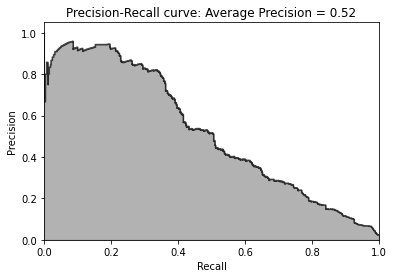

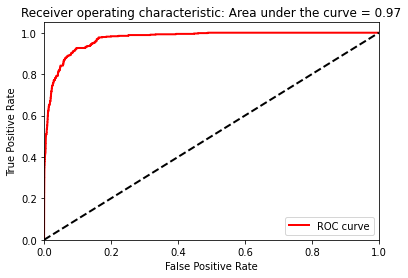

In [ ]:
precision, recall, thresholds = \
    precision_recall_curve(y_test,y_pred)

thI = np.argmax(np.divide(np.multiply(precision,recall),np.add(precision, recall))[:-3])
print(thI)
print(precision[thI])
print(recall[thI])
print((2*precision[thI] *recall[thI])/(precision[thI]+ recall[thI]))

average_precision = \
    average_precision_score(y_test,y_pred)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = \
    roc_curve(y_test,y_pred)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [ ]:
fnscore =  [ (fname,socre) for fname,socre in zip(gbm.feature_name(),gbm.feature_importance())]
top_feature = sorted(fnscore, key=lambda tup: tup[1], reverse=True)[:25]

In [ ]:
# #if error: cannot import name '_png' from 'matplotlib', run following code
# !sudo python -m pip uninstall matplotlib
# !pip install matplotlib==3.1.3